# Benchmarking `gpujpeg` 📊

In [ ]:
%run benchmark_gpujpeg_LoLa.py

# 📈 Data Visualization & Analysis

Now we will plot the collected data to understand the results. We will focus on:
1.  **Rate-Distortion:** How do quality metrics (like VMAF) change with file size?
2.  **Quality vs. File Size:** How does the `-quality` setting impact file size for different subsampling methods?
3.  **Encoding Performance:** Which Format method is fastest? How does resolution affect encoding time?
4.  **Decoding Performance:** How does resolution affect decoding time?

In [2]:
# --- Main Configuration ---
# Resolutions to test (Name: (Width, Height))
RESOLUTIONS = {
    '1280x720': (1280, 720),
    '1920x1080': (1920, 1080),
    '3840x2160': (3840, 2160),
}

RESOLUTION_TO_FILENAME = {
    '1280x720': 'frame_hd.rgb',
    '1920x1080': 'frame_fullhd.rgb',
    '3840x2160': 'frame_ultrahd.rgb',
}

# Parameters to benchmark
QUALITIES = range(10, 101, 1)
FORMATS = ['planar', 'interleaved']
SUBSAMPLINGS = ['4:4:4', '4:2:2', '4:2:0']
RESTART_INTERVALS = [0, 1, 2, 4, 8, 16, 32, 64, 128]

SUBSAMPLING_TO_PARAM = {
    '4:4:4': '444',
    '4:2:2': '422',
    '4:2:0': '420'
}

In [3]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('results_gpujpeg_LoLa.csv')
df.head()

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame
0,1280x720,40,interleaved,8,4:2:0,100,0.000456,0.198407,0.001137,0.000418,0.124319,0.000869,30.490,41.813770,0.958803,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1
1,1280x720,41,interleaved,8,4:2:0,100,0.000431,0.116106,0.000584,0.000419,0.115927,0.000854,30.767,41.917995,0.958288,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1
2,1280x720,42,interleaved,8,4:2:0,100,0.000431,0.126549,0.001100,0.000414,0.123871,0.000867,30.954,41.774227,0.958155,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1
3,1280x720,43,interleaved,8,4:2:0,100,0.000437,0.116701,0.001071,0.000417,0.115428,0.000854,31.024,41.787632,0.958230,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1
4,1280x720,44,interleaved,8,4:2:0,100,0.000436,0.125267,0.001097,0.000414,0.117615,0.000860,31.289,42.038006,0.959574,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1


In [5]:
# Set plot style
sns.set_theme(style="whitegrid")

## Encoding Parameters vs. quality metrics

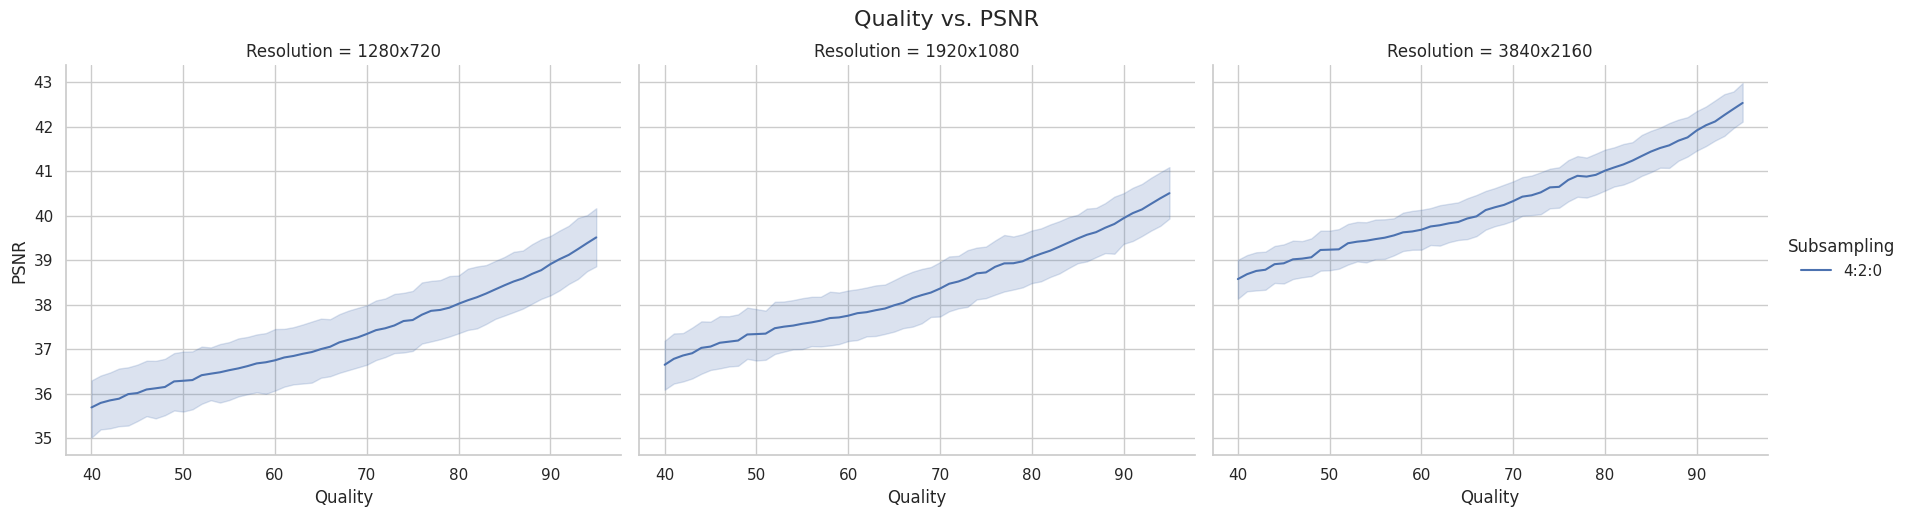

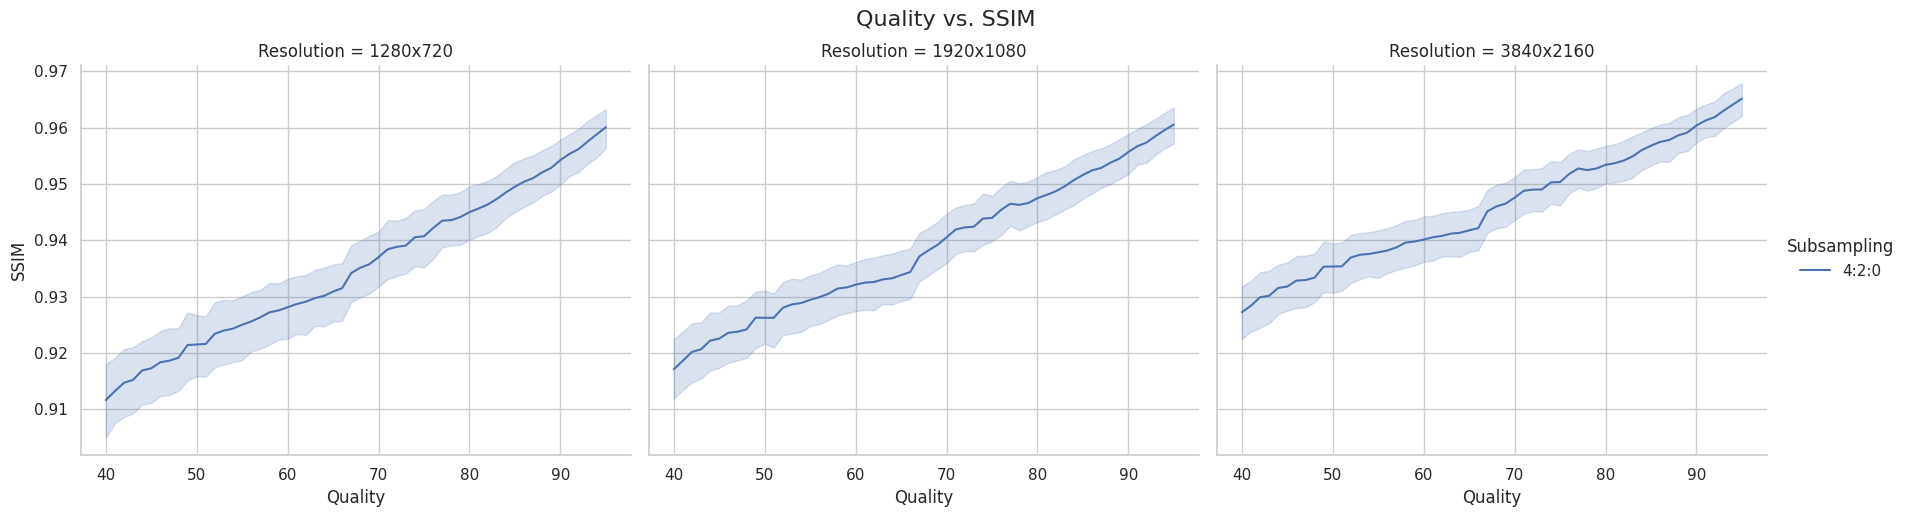

In [6]:
x = 'Quality'
y = 'PSNR'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

x = 'Quality'
y = 'SSIM'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

## Encoding Parameters vs. File Size


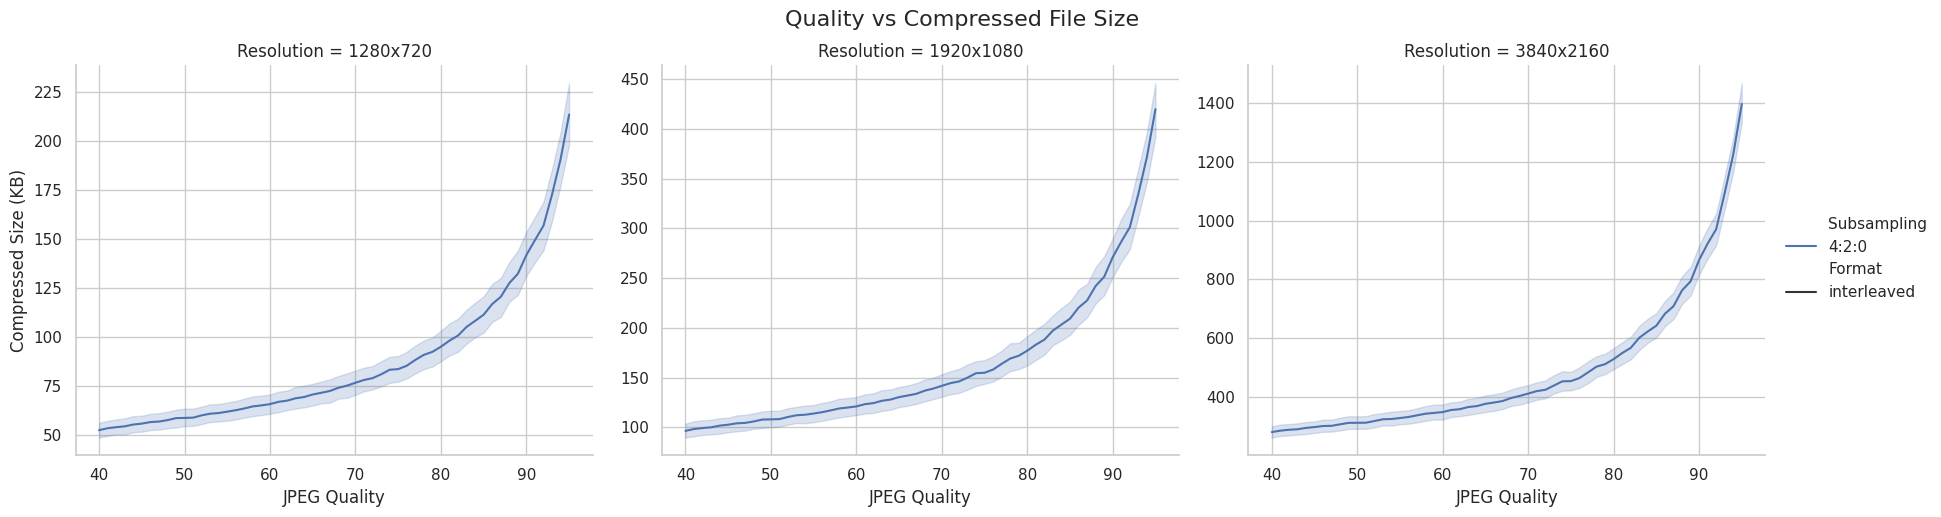

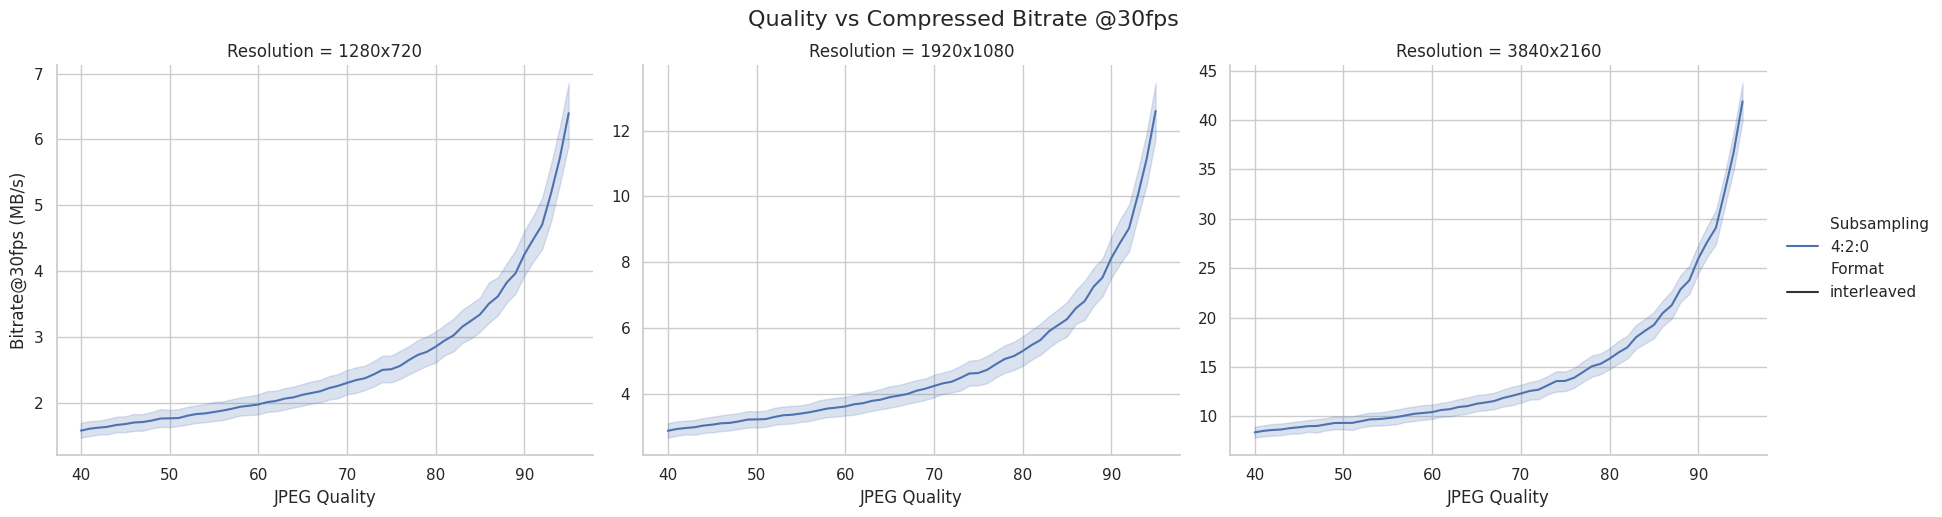

In [7]:
g = sns.relplot(
    data=df,
    x='Quality',
    y='Compressed Size (KB)',
    hue='Subsampling',
    style='Format',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Compressed File Size', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Compressed Size (KB)')
plt.show()

fps = 30
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Compressed Size (KB)'] * fps / 1000,
    hue='Subsampling',
    style='Format',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False},
)
g.figure.suptitle(f'Quality vs Compressed Bitrate @{fps}fps', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', f'Bitrate@{fps}fps (MB/s)')
plt.show()

We can observe an explosion in file size from quality 95 onwards, and a sharp increase from quality 90 onwards.

## Encoding Parameters vs. Performance

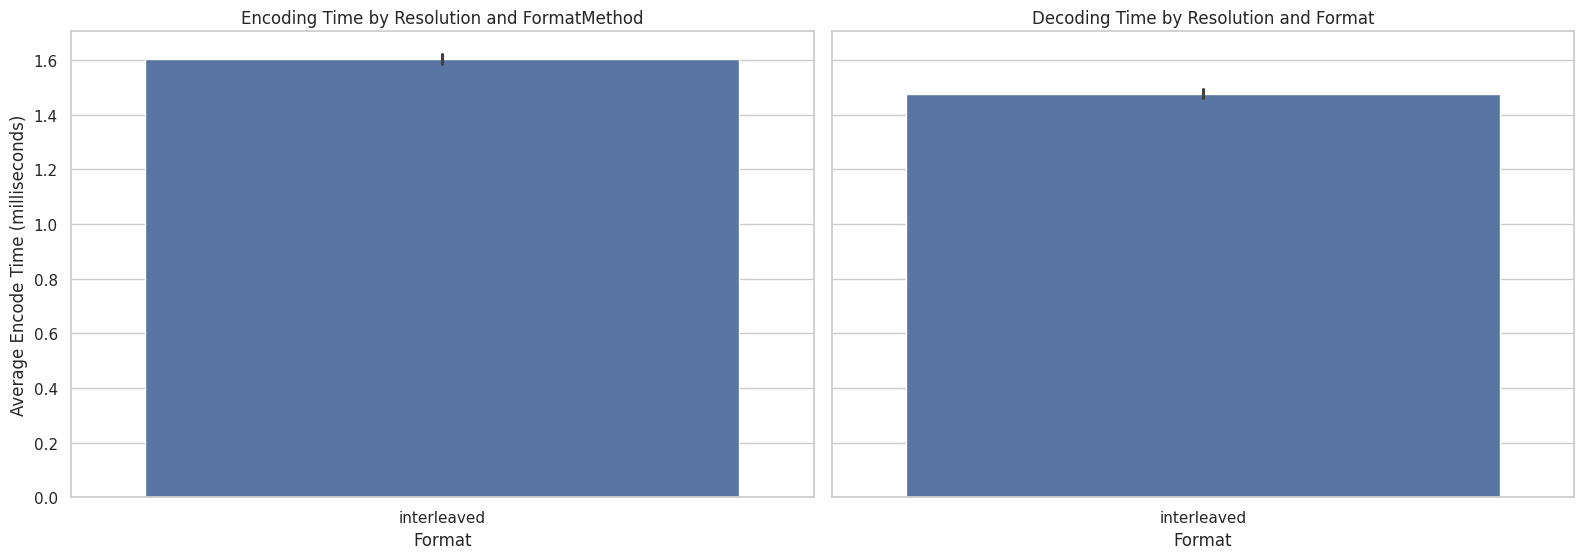

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot 1: Encoding time by Resolution and Format
#method
sns.barplot(
    data=df,
    x='Format',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_title('Encoding Time by Resolution and FormatMethod')
ax[0].set_ylabel('Average Encode Time (milliseconds)')
ax[0].set_xlabel('Format')
# Plot 2: Decoding time by Resolution and Format
#method
sns.barplot(
    data=df,
    x='Format',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_title('Decoding Time by Resolution and Format')
ax[1].set_ylabel('Average Decode Time (milliseconds)')
ax[1].set_xlabel('Format')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

In [9]:
df = df[df['Format'] == 'interleaved']

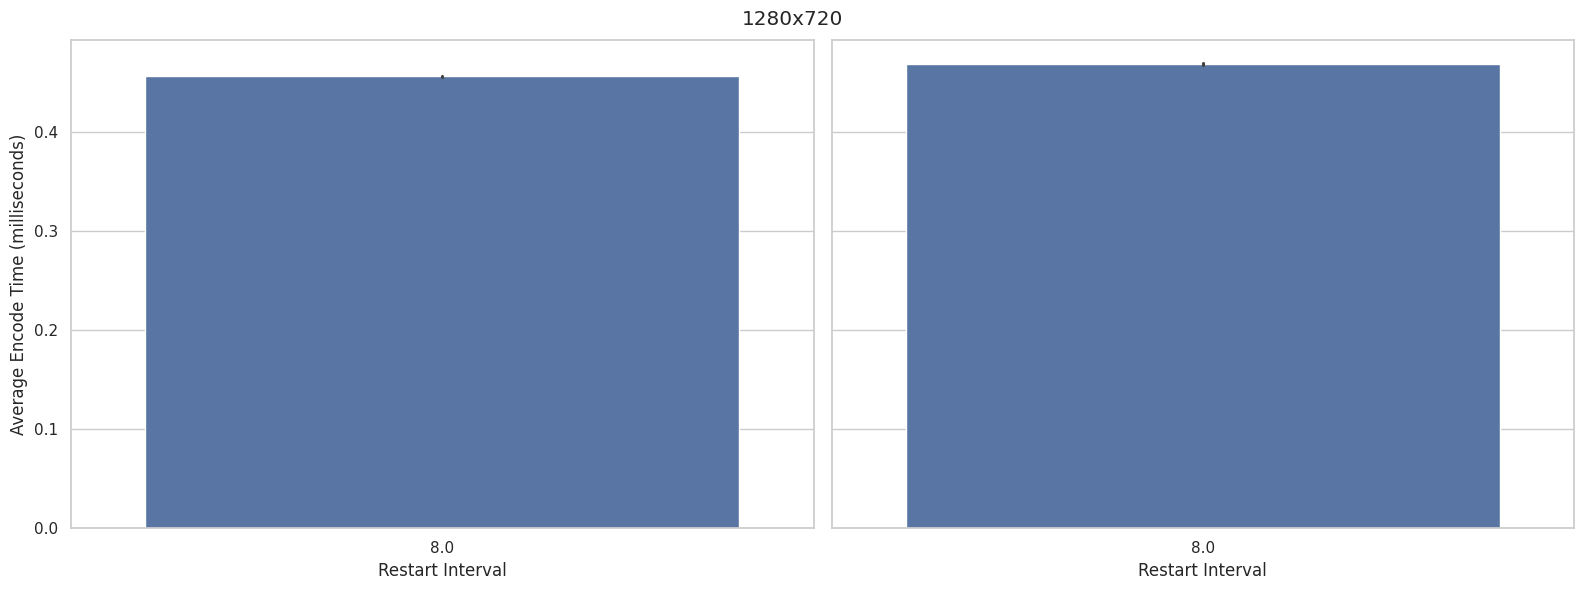

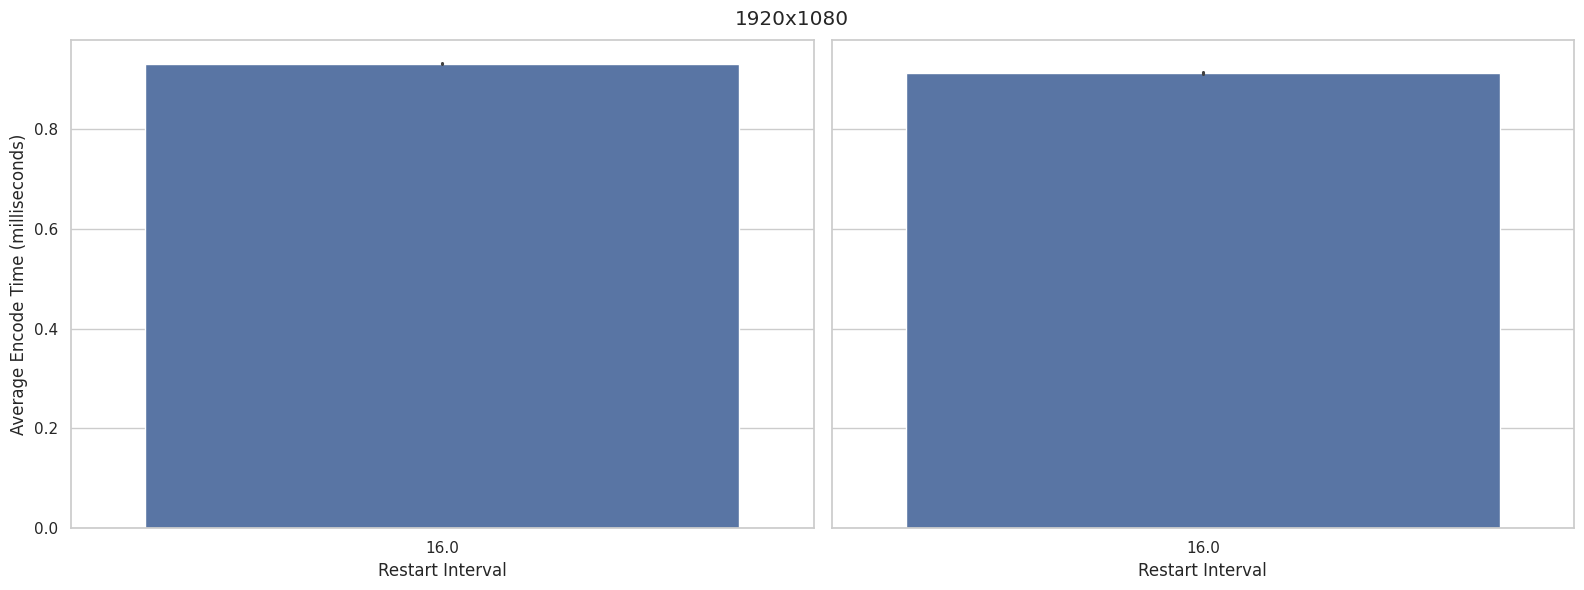

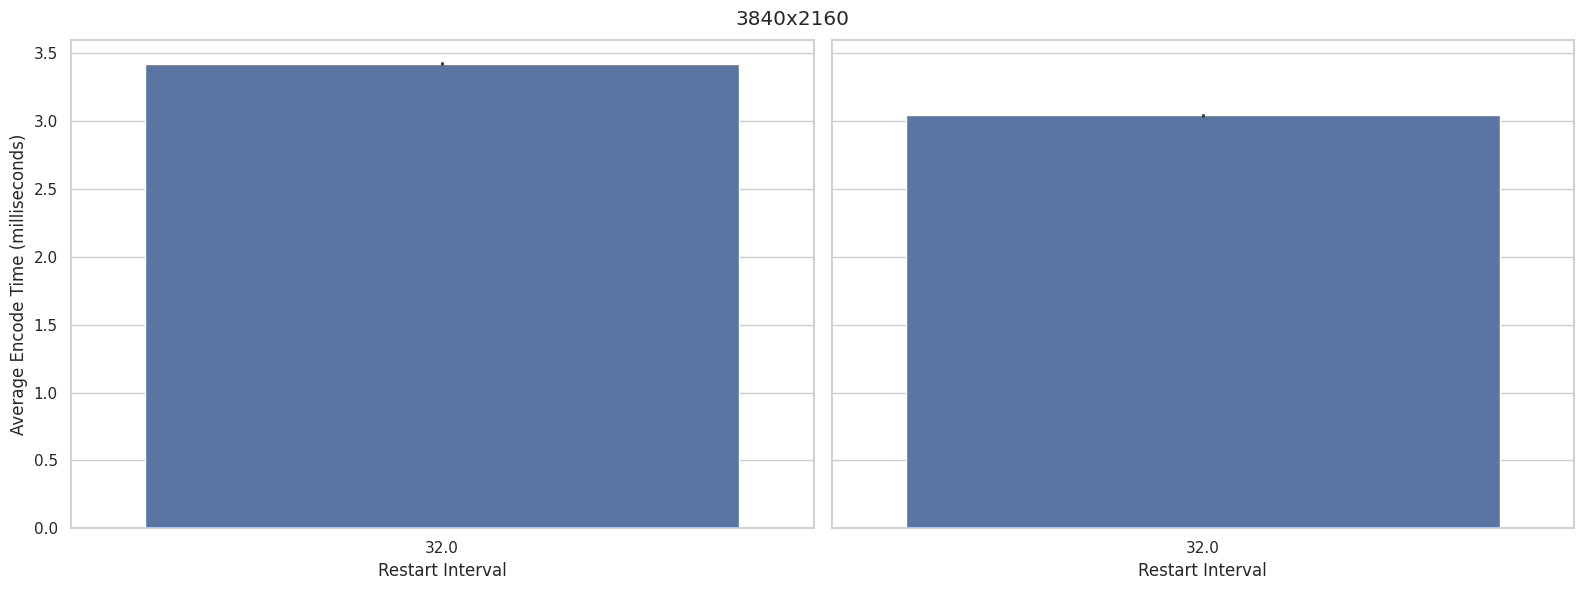

In [10]:
# 1280x720
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '1280x720'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '1280x720'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("1280x720")
plt.show()

# 1920x1080
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '1920x1080'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '1920x1080'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("1920x1080")
plt.show()

# 3840x2160
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '3840x2160'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '3840x2160'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("3840x2160")
plt.show()

In [11]:
df = df[df['Restart Interval'] > 0]

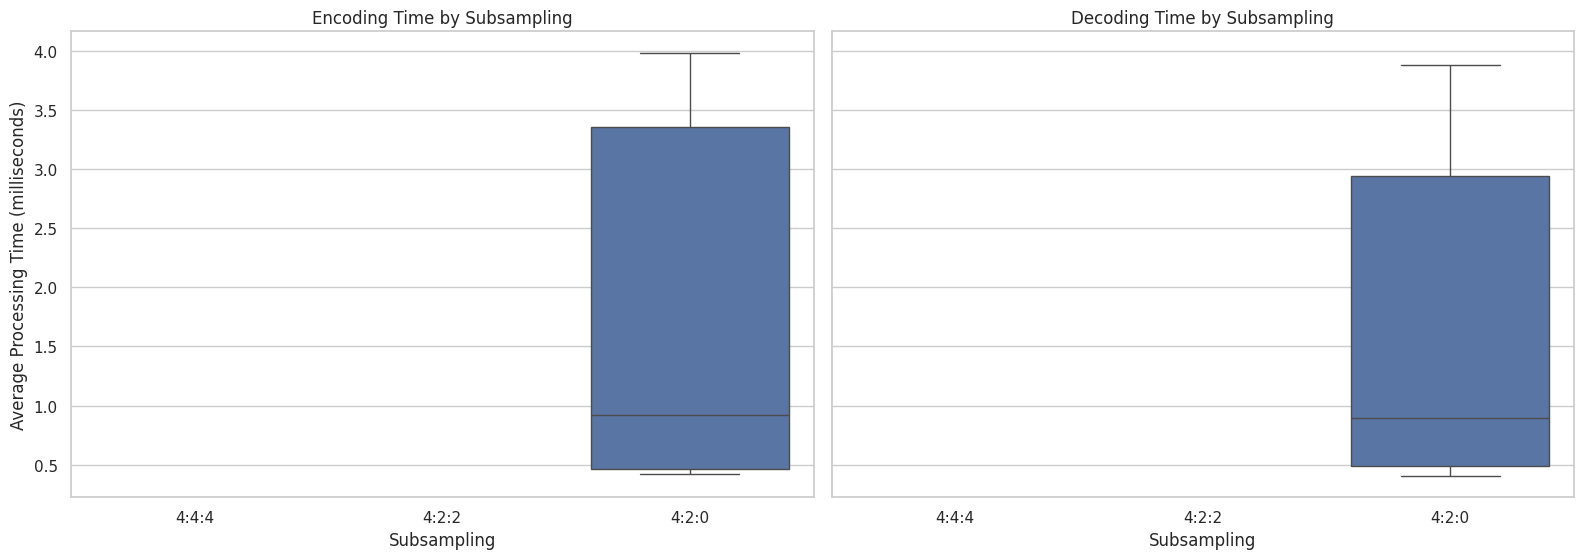

In [12]:
## Encoding Parameters vs. Performance
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Subsampling method
sns.boxplot(
    data=df,
    x='Subsampling',
    y=df['Avg Encode Time (s)'] * 1000,
    order=SUBSAMPLINGS,
    ax=ax[0]
)
ax[0].set_title('Encoding Time by Subsampling')
ax[0].set_ylabel('Average Processing Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.boxplot(
    data=df,
    x='Subsampling',
    y=df['Avg Decode Time (s)'] * 1000,
    order=SUBSAMPLINGS,
    ax=ax[1]
)
ax[1].set_title('Decoding Time by Subsampling')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

In [13]:
df = df[df['Subsampling'] == "4:2:0"]

In [14]:
df_hd = df[(df['Restart Interval'] == 8) & (df['Resolution'] == "1280x720")]
df_fullhd = df[(df['Restart Interval'] == 16) & (df['Resolution'] == "1920x1080")]
df_ultrahd = df[(df['Restart Interval'] == 32) & (df['Resolution'] == "3840x2160")]
df = df[((df['Restart Interval'] == 8) & (df['Resolution'] == "1280x720")) | ((df['Restart Interval'] == 16) & (df['Resolution'] == "1920x1080")) | ((df['Restart Interval'] == 32) & (df['Resolution'] == "3840x2160"))]

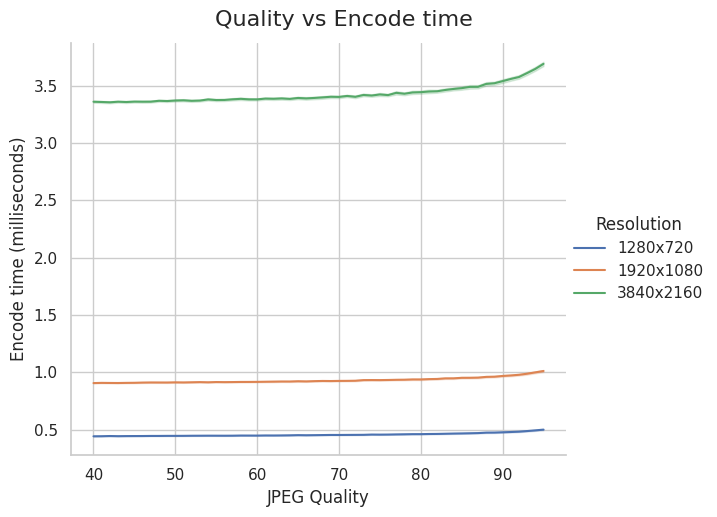

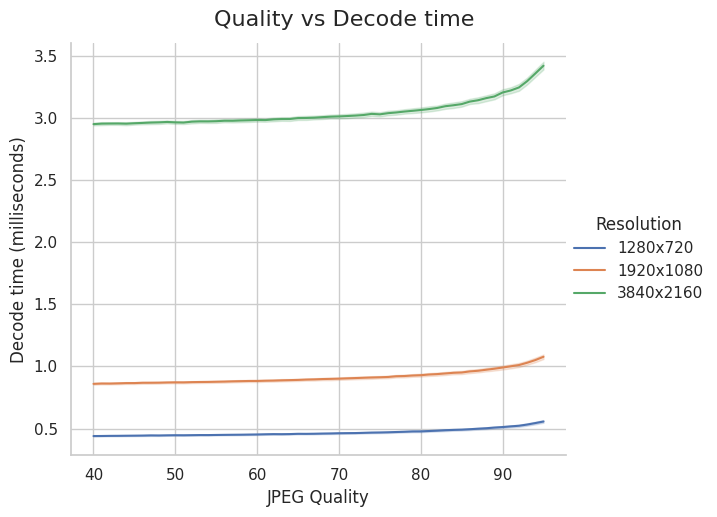

In [15]:
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Encode Time (s)'] * 1000,
    hue='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Encode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Encode time (milliseconds)')
plt.show()

g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Decode Time (s)'] * 1000,
    hue='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Decode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Decode time (milliseconds)')
plt.show()

In [16]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 2 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 2]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 2]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame
14391,1920x1080,95,interleaved,16,4:2:0,100,0.001036,0.125245,0.001799,0.001151,0.123206,0.001149,426.664,39.240345,0.983017,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,86
2911,1280x720,95,interleaved,8,4:2:0,100,0.000459,0.124546,0.001091,0.000481,0.117817,0.000858,91.141,47.134331,0.983016,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2910,1280x720,94,interleaved,8,4:2:0,100,0.000457,0.116768,0.000598,0.000467,0.120283,0.000851,76.754,47.030422,0.982883,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
11703,1920x1080,95,interleaved,16,4:2:0,100,0.001033,0.122108,0.000688,0.001175,0.122506,0.001179,397.856,39.884491,0.982713,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,70
2909,1280x720,93,interleaved,8,4:2:0,100,0.000453,0.125241,0.001099,0.000466,0.127327,0.000871,68.153,46.932655,0.982646,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18


In [17]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 1.5 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1.5]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame
14391,1920x1080,95,interleaved,16,4:2:0,100,0.001036,0.125245,0.001799,0.001151,0.123206,0.001149,426.664,39.240345,0.983017,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,86
2911,1280x720,95,interleaved,8,4:2:0,100,0.000459,0.124546,0.001091,0.000481,0.117817,0.000858,91.141,47.134331,0.983016,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2910,1280x720,94,interleaved,8,4:2:0,100,0.000457,0.116768,0.000598,0.000467,0.120283,0.000851,76.754,47.030422,0.982883,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
11703,1920x1080,95,interleaved,16,4:2:0,100,0.001033,0.122108,0.000688,0.001175,0.122506,0.001179,397.856,39.884491,0.982713,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,70
2909,1280x720,93,interleaved,8,4:2:0,100,0.000453,0.125241,0.001099,0.000466,0.127327,0.000871,68.153,46.932655,0.982646,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18


In [18]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 1 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1]
df[df['Resolution'] == '1280x720'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame
2911,1280x720,95,interleaved,8,4:2:0,100,0.000459,0.124546,0.001091,0.000481,0.117817,0.000858,91.141,47.134331,0.983016,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2910,1280x720,94,interleaved,8,4:2:0,100,0.000457,0.116768,0.000598,0.000467,0.120283,0.000851,76.754,47.030422,0.982883,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2909,1280x720,93,interleaved,8,4:2:0,100,0.000453,0.125241,0.001099,0.000466,0.127327,0.000871,68.153,46.932655,0.982646,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2907,1280x720,91,interleaved,8,4:2:0,100,0.000447,0.121388,0.001139,0.000452,0.123910,0.000874,56.448,46.873058,0.982205,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2908,1280x720,92,interleaved,8,4:2:0,100,0.000445,0.122052,0.000613,0.000458,0.122453,0.000857,59.459,46.891716,0.982205,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18


In [19]:
df[df['Resolution'] == '1920x1080'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame
9351,1920x1080,95,interleaved,16,4:2:0,100,0.000964,0.121330,0.001736,0.001011,0.124010,0.001177,272.248,45.312008,0.981014,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,56
9350,1920x1080,94,interleaved,16,4:2:0,100,0.000973,0.118562,0.001685,0.000988,0.120577,0.001198,238.528,45.136520,0.980391,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,56
2967,1920x1080,95,interleaved,16,4:2:0,100,0.000956,0.118011,0.001693,0.000973,0.118976,0.001119,198.052,46.729095,0.979813,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2966,1920x1080,94,interleaved,16,4:2:0,100,0.000928,0.120225,0.001734,0.000945,0.116097,0.001145,163.119,46.643982,0.979691,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
9349,1920x1080,93,interleaved,16,4:2:0,100,0.000943,0.122945,0.001690,0.000965,0.117783,0.001155,215.284,44.968182,0.979672,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,56


In [20]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 0.5 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 0.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 0.5]
df[df['Resolution'] == '1280x720'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame
2911,1280x720,95,interleaved,8,4:2:0,100,0.000459,0.124546,0.001091,0.000481,0.117817,0.000858,91.141,47.134331,0.983016,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2910,1280x720,94,interleaved,8,4:2:0,100,0.000457,0.116768,0.000598,0.000467,0.120283,0.000851,76.754,47.030422,0.982883,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2909,1280x720,93,interleaved,8,4:2:0,100,0.000453,0.125241,0.001099,0.000466,0.127327,0.000871,68.153,46.932655,0.982646,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2907,1280x720,91,interleaved,8,4:2:0,100,0.000447,0.121388,0.001139,0.000452,0.123910,0.000874,56.448,46.873058,0.982205,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2908,1280x720,92,interleaved,8,4:2:0,100,0.000445,0.122052,0.000613,0.000458,0.122453,0.000857,59.459,46.891716,0.982205,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18


In [21]:
df[df['Resolution'] == '1920x1080'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame


In [22]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 0.45 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 0.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 0.5]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame
2907,1280x720,91,interleaved,8,4:2:0,100,0.000447,0.121388,0.001139,0.000452,0.123910,0.000874,56.448,46.873058,0.982205,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2906,1280x720,90,interleaved,8,4:2:0,100,0.000445,0.118705,0.000568,0.000455,0.121169,0.000882,53.863,46.815453,0.981955,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2905,1280x720,89,interleaved,8,4:2:0,100,0.000447,0.125750,0.001094,0.000452,0.122656,0.000864,49.693,46.499252,0.981603,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2903,1280x720,87,interleaved,8,4:2:0,100,0.000445,0.120684,0.000587,0.000448,0.126276,0.000856,45.452,46.378601,0.981218,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
2902,1280x720,86,interleaved,8,4:2:0,100,0.000446,0.119526,0.000566,0.000445,0.118926,0.000853,44.528,46.428108,0.980563,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,18
